In [123]:
import json
import collections
from pathlib import Path
from warnings import warn

import numpy as np

from astropy import table

import jwst
from jwst import datamodels

from tqdm.notebook import tqdm

from astropy import visualization
from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
dl_path = Path('mastDownload/')

def find_filepath(name, dirpath=dl_path):
    i = dirpath.glob(f'**/{name}')
    l = list(i)
    if len(l) == 0:
        raise ValueError(f'filename {name} is not present in {dirpath}')
    elif len(l)>1:
        warn(f'file {name} has {len(l)} entries in {dirpath}')
    return l[0]
        

In [21]:
n6791_prods = table.Table.read('NGC6791_dataproducts.ecsv', format='ascii.ecsv')

prodmap = {}
local_paths = []
dubious_paths = []
for prod in n6791_prods:
    nm = prod['productFilename']
    if nm in prodmap:
        lpath, dub = prodmap[nm]
        local_paths.append(lpath)
        dubious_paths.append(dub)
    else:
        it = dl_path.glob(f'**/{nm}')
        first = next(it)
        try:
            second = next(it)
        except StopIteration:
            second = None
        local_paths.append(str(first))
        dubious_paths.append(second is not None)
        prodmap[nm] = local_paths[-1], dubious_paths[-1]
n6791_prods['localPath'] = local_paths
n6791_prods['ambiguousLocalPath'] = dubious_paths

n6791_prods

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,localPath,ambiguousLocalPath
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str16,int64,str108,bool
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,source/target (L3) : association generator,D,mast:JWST/product/jw02609-o010_20230829t055528_spec3_00001_asn.json,INFO,Minimum Recommended Products,ASN,--,CALJWST,1.11.4,2609,jw02609-o010_20230829t055528_spec3_00001_asn.json,4448,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s01765_nirspec_f100lp-g140h/jw02609-o010_20230829t055528_spec3_00001_asn.json,True
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,source/target (L3) : association pool,D,mast:JWST/product/jw02609_20230829t055528_pool.csv,INFO,Minimum Recommended Products,POOL,--,CALJWST,1.11.4,2609,jw02609_20230829t055528_pool.csv,76603,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s01765_nirspec_f100lp-g140h/jw02609_20230829t055528_pool.csv,True
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.jpg,PREVIEW,--,--,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_cal.jpg,3063,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.jpg,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.jpg,PREVIEW,--,--,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_crf.jpg,3063,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_crf.jpg,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,Preview-Full,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.jpg,PREVIEW,--,--,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.jpg,9805,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_s2d.jpg,False
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,5126400,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150909879,JWST,spectrum,jw02609010001_03101_00002_nrs2,exposure/target (L2b/L3): 1D extracted spectrum,S,mast:JWST/product/jw02609010001_03101_00002_nrs2_x1d.fits,SCIENCE,--,X1D,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs2_x1d.fits,23014080,150936686,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_x1d.fits,False
150909879,JWST,spectrum,jw02609010001_03101_00002_nrs2,exposure/target (L2b/L3): 1D extracted spectrum,S,mast:JWST/product/jw02609010001_03101_00002_nrs2_x1d.fits,SCIENCE,--,X1D,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs2_x1d.fits,23014080,150936695,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_x1d.fits,False


In [45]:
set(n6791_prods['description'])

{'FGS guide star fine guide',
 'FGS guide star identification',
 'FGS guide star tracking',
 'FGS1 guide star acquisition',
 'FGS2 guide star acquisition',
 'MSA metadata',
 'Preview-Full',
 'exposure (L1b): Uncalibrated 4D exposure data',
 'exposure (L2a): 2D count rate averaged over integrations',
 'exposure (L2a): 3D countrate per integration',
 'exposure (L2b): 2D calibrated exposure average over integrations',
 'exposure/target (L2b/L3): 1D extracted spectrum',
 'exposure/target (L2b/L3): 2D Calibrated data averaged over integrations',
 'exposure/target (L2b/L3): 2D image of spectrum avg integrations',
 'source/target (L3) : association generator',
 'source/target (L3) : association pool'}

In [47]:
n6791_prods[np.array(['L2a' in row['description'] for row in n6791_prods])]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,localPath,ambiguousLocalPath
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str16,int64,str108,bool
89376205,JWST,image,jw02609008001_02101_00001_nrs1,exposure (L2a): 2D count rate averaged over integrations,S,mast:JWST/product/jw02609008001_02101_00001_nrs1_rate.fits,SCIENCE,Minimum Recommended Products,RATE,--,CALJWST,1.6.2,2609,jw02609008001_02101_00001_nrs1_rate.fits,83946240,89376205,PUBLIC,2,mastDownload/JWST/jw02609008001_02101_00001_nrs1/jw02609008001_02101_00001_nrs1_rate.fits,False
89376205,JWST,image,jw02609008001_02101_00001_nrs1,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw02609008001_02101_00001_nrs1_rateints.fits,SCIENCE,Minimum Recommended Products,RATEINTS,--,CALJWST,1.6.2,2609,jw02609008001_02101_00001_nrs1_rateints.fits,83952000,89376205,PUBLIC,2,mastDownload/JWST/jw02609008001_02101_00001_nrs1/jw02609008001_02101_00001_nrs1_rateints.fits,False
89376208,JWST,image,jw02609008001_02101_00001_nrs2,exposure (L2a): 2D count rate averaged over integrations,S,mast:JWST/product/jw02609008001_02101_00001_nrs2_rate.fits,SCIENCE,Minimum Recommended Products,RATE,--,CALJWST,1.6.2,2609,jw02609008001_02101_00001_nrs2_rate.fits,83946240,89376208,PUBLIC,2,mastDownload/JWST/jw02609008001_02101_00001_nrs2/jw02609008001_02101_00001_nrs2_rate.fits,False
89376208,JWST,image,jw02609008001_02101_00001_nrs2,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw02609008001_02101_00001_nrs2_rateints.fits,SCIENCE,Minimum Recommended Products,RATEINTS,--,CALJWST,1.6.2,2609,jw02609008001_02101_00001_nrs2_rateints.fits,83952000,89376208,PUBLIC,2,mastDownload/JWST/jw02609008001_02101_00001_nrs2/jw02609008001_02101_00001_nrs2_rateints.fits,False
89376201,JWST,image,jw02609008001_02101_00002_nrs1,exposure (L2a): 2D count rate averaged over integrations,S,mast:JWST/product/jw02609008001_02101_00002_nrs1_rate.fits,SCIENCE,Minimum Recommended Products,RATE,--,CALJWST,1.6.2,2609,jw02609008001_02101_00002_nrs1_rate.fits,83946240,89376201,PUBLIC,2,mastDownload/JWST/jw02609008001_02101_00002_nrs1/jw02609008001_02101_00002_nrs1_rate.fits,False
89376201,JWST,image,jw02609008001_02101_00002_nrs1,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw02609008001_02101_00002_nrs1_rateints.fits,SCIENCE,Minimum Recommended Products,RATEINTS,--,CALJWST,1.6.2,2609,jw02609008001_02101_00002_nrs1_rateints.fits,83952000,89376201,PUBLIC,2,mastDownload/JWST/jw02609008001_02101_00002_nrs1/jw02609008001_02101_00002_nrs1_rateints.fits,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150909879,JWST,spectrum,jw02609010001_03101_00002_nrs2,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw02609010001_03101_00002_nrs2_rateints.fits,SCIENCE,--,RATEINTS,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs2_rateints.fits,167829120,150936686,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_rateints.fits,False
150909879,JWST,spectrum,jw02609010001_03101_00002_nrs2,exposure (L2a): 3D countrate per integration,S,mast:JWST/product/jw02609010001_03101_00002_nrs2_rateints.fits,SCIENCE,--,RATEINTS,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs2_rateints.fits,167829120,150936695,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_rateints.fits,False


In [46]:
np.unique(n6791_prods[n6791_prods['calib_level'] == 2]['description'])

FGS guide star fine guide
FGS guide star identification
FGS guide star tracking
FGS1 guide star acquisition
FGS2 guide star acquisition
Preview-Full
exposure (L2a): 2D count rate averaged over integrations
exposure (L2a): 3D countrate per integration
exposure (L2b): 2D calibrated exposure average over integrations
exposure/target (L2b/L3): 1D extracted spectrum
exposure/target (L2b/L3): 2D image of spectrum avg integrations


In [44]:
n6791_prods[n6791_prods['productSubGroupDescription'] == 'CAL']

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,localPath,ambiguousLocalPath
str9,str4,str8,str40,str71,str1,str68,str9,str28,str8,str1,str7,str6,str4,str50,int64,str9,str16,int64,str108,bool
150936210,JWST,spectrum,jw02609-o010_s00010_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,5126400,150936210,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00010_nirspec_f100lp-g140h/jw02609-o010_s00010_nirspec_f100lp-g140h_cal.fits,False
150936716,JWST,spectrum,jw02609-o010_s00021_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00021_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00021_nirspec_f100lp-g140h_cal.fits,7315200,150936716,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00021_nirspec_f100lp-g140h/jw02609-o010_s00021_nirspec_f100lp-g140h_cal.fits,False
150936279,JWST,spectrum,jw02609-o010_s00038_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00038_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00038_nirspec_f100lp-g140h_cal.fits,4636800,150936279,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00038_nirspec_f100lp-g140h/jw02609-o010_s00038_nirspec_f100lp-g140h_cal.fits,False
150936236,JWST,spectrum,jw02609-o010_s00040_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00040_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00040_nirspec_f100lp-g140h_cal.fits,4573440,150936236,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00040_nirspec_f100lp-g140h/jw02609-o010_s00040_nirspec_f100lp-g140h_cal.fits,False
150936529,JWST,spectrum,jw02609-o010_s00042_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00042_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00042_nirspec_f100lp-g140h_cal.fits,4573440,150936529,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00042_nirspec_f100lp-g140h/jw02609-o010_s00042_nirspec_f100lp-g140h_cal.fits,False
150936060,JWST,spectrum,jw02609-o010_s00066_nirspec_f100lp-g140h,exposure (L2b): 2D calibrated exposure average over integrations,D,mast:JWST/product/jw02609-o010_s00066_nirspec_f100lp-g140h_cal.fits,SCIENCE,Minimum Recommended Products,CAL,--,CALJWST,1.11.4,2609,jw02609-o010_s00066_nirspec_f100lp-g140h_cal.fits,6785280,150936060,EXCLUSIVE_ACCESS,3,mastDownload/JWST/jw02609-o010_s00066_nirspec_f100lp-g140h/jw02609-o010_s00066_nirspec_f100lp-g140h_cal.fits,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150909879,JWST,spectrum,jw02609010001_03101_00002_nrs2,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00002_nrs2_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs2_cal.fits,154019520,150936686,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_00002_nrs2/jw02609010001_03101_00002_nrs2_cal.fits,False
150909879,JWST,spectrum,jw02609010001_03101_00002_nrs2,exposure (L2b): 2D calibrated exposure average over integrations,S,mast:JWST/product/jw02609010001_03101_00002_nrs2_cal.fits,SCIENCE,--,CAL,--,CALJWST,1.10.1,2609,jw02609010001_03101_00002_nrs2_cal.fits,154019520,150936695,EXCLUSIVE_ACCESS,2,mastDownload/JWST/jw02609010001_03101_0000

In [ ]:
rates = set(n6791_prods[n6791_prods['productSubGroupDescription'] == 'RATE']['localPath'])
nrs1rates = [r for r in rates if 'nrs1' in r]

nrs1rate = jwst.datamodels.open(nrs1rates[0])
nrs2rate = jwst.datamodels.open(nrs1rates[0].replace('nrs1', 'nrs2'))

In [32]:
cals = set(n6791_prods[n6791_prods['productSubGroupDescription'] == 'CAL']['localPath'])
nrs1_cals = [cal for cal in cals if 'nrs1' in cal]

nrs1cal = jwst.datamodels.open(nrs1_cals[0])
nrs2cal = jwst.datamodels.open(nrs1_cals[0].replace('nrs1', 'nrs2'))

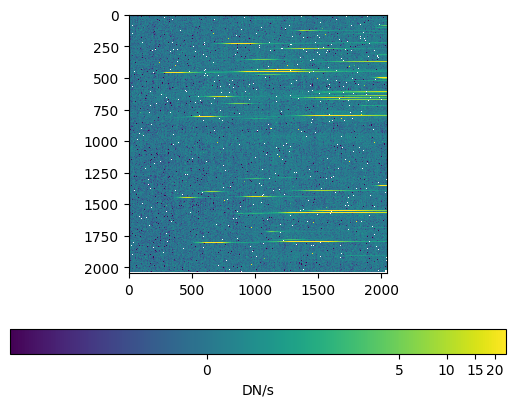

In [57]:
visualization.imshow_norm(nrs1rate.data,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         )
plt.colorbar(orientation='horizontal').set_label(nrs1rate.meta.bunit_data)

The  rate images have no WCS? Apparently that's expected

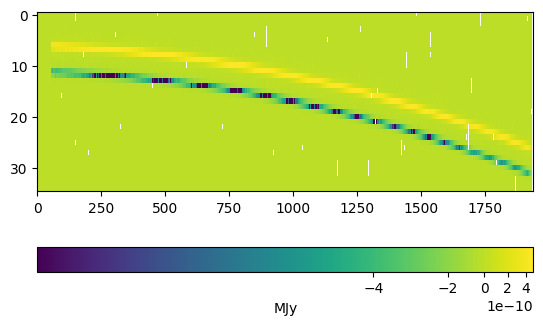

In [91]:
sl = nrs2cal.slits[0]

visualization.imshow_norm(sl.data, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LogStretch(),
                          interpolation='nearest'
                         )
plt.colorbar(orientation='horizontal').set_label(sl.meta.bunit_data)

Text(0.5, 1.0, 'dec')

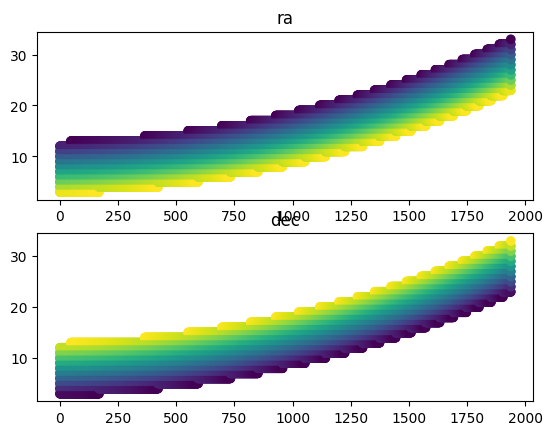

In [110]:
ypx, xpx = np.meshgrid(*[np.arange(sh) for sh in sl.data.shape])
sc, wl = sl.meta.wcs.pixel_to_world(xpx, ypx)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.scatter(xpx, ypx, c=sc.ra.deg)
ax1.set_title('ra')
ax2.scatter(xpx, ypx, c=sc.dec.deg)
ax2.set_title('dec')

Now compute the differential pixel vector

Text(0.5, 1.0, 'dy (px per arcsec)')

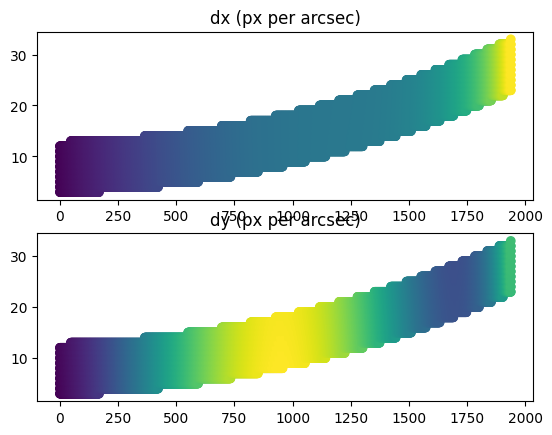

In [128]:
raoff = sc.ra + 1*u.marcsec
decoff = sc.dec + 1*u.marcsec
newsky = SkyCoord(ra=raoff, dec=decoff)
xoff, yoff = sl.meta.wcs.world_to_pixel(newsky, wl)

dx = xoff - xpx
dy = yoff - ypx

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.scatter(xpx, ypx, c=dx*1000)
ax1.set_title('dx (px per arcsec)')
ax2.scatter(xpx, ypx, c=dy*1000)
ax2.set_title('dy (px per arcsec)')

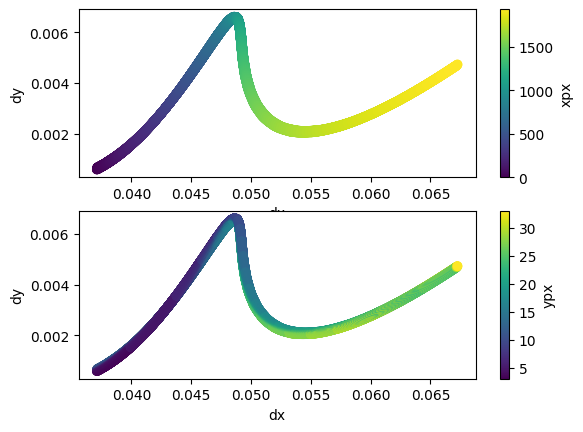

In [149]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.colorbar(ax1.scatter(dx, dy, c=xpx)).set_label('xpx')
fig.colorbar(ax2.scatter(dx, dy, c=ypx)).set_label('ypx')
for ax in (ax1, ax2):
    ax.set_xlabel('dx')
    ax.set_ylabel('dy')

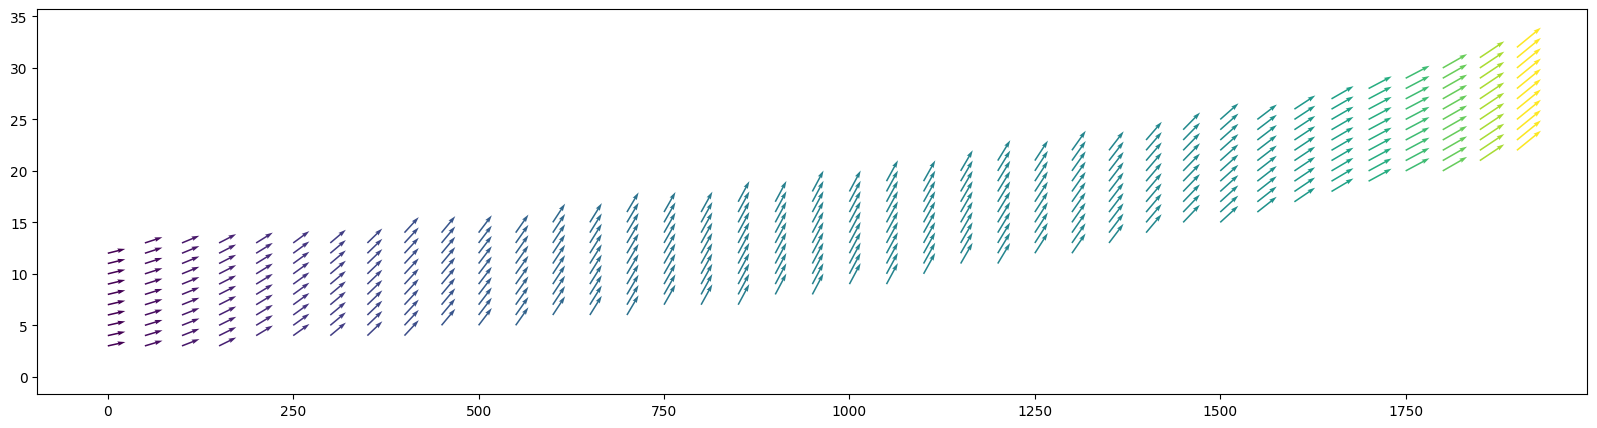

In [178]:
sel = slice(None, None, 50)

plt.figure(figsize=(20, 5))
plt.quiver(xpx[sel], ypx[sel], dx[sel], dy[sel], np.hypot(dx[sel], dy[sel]), angles='xy', 
           width=.001)

In [213]:
ypx, xpx = np.meshgrid(*[np.arange(sh) for sh in sl.data.shape])
sc, wl = sl.meta.wcs.pixel_to_world(xpx, ypx)

sl.meta.wcs.world_to_pixel(sc, wl)

[array([[       nan,        nan,        nan, ..., 0.0464812 , 0.04647971,
                nan],
        [       nan,        nan,        nan, ..., 1.04650688, 1.04650537,
                nan],
        [       nan,        nan,        nan, ..., 2.04653256, 2.04653103,
                nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan]]),
 array([[        nan,         nan,         nan, ..., 17.00070599,
         18.00071718,         nan],
        [        nan,         nan,         nan, ..., 17.00070939,
         18.00072056,         nan],
        [        nan,         nan,         nan, ..., 17.00071277,
         18.00072392,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,   

Uhm... p2w -> w2p does not round trip??  OK, well, lets see what happens if you get the difference from the non-round-tripped version instead...

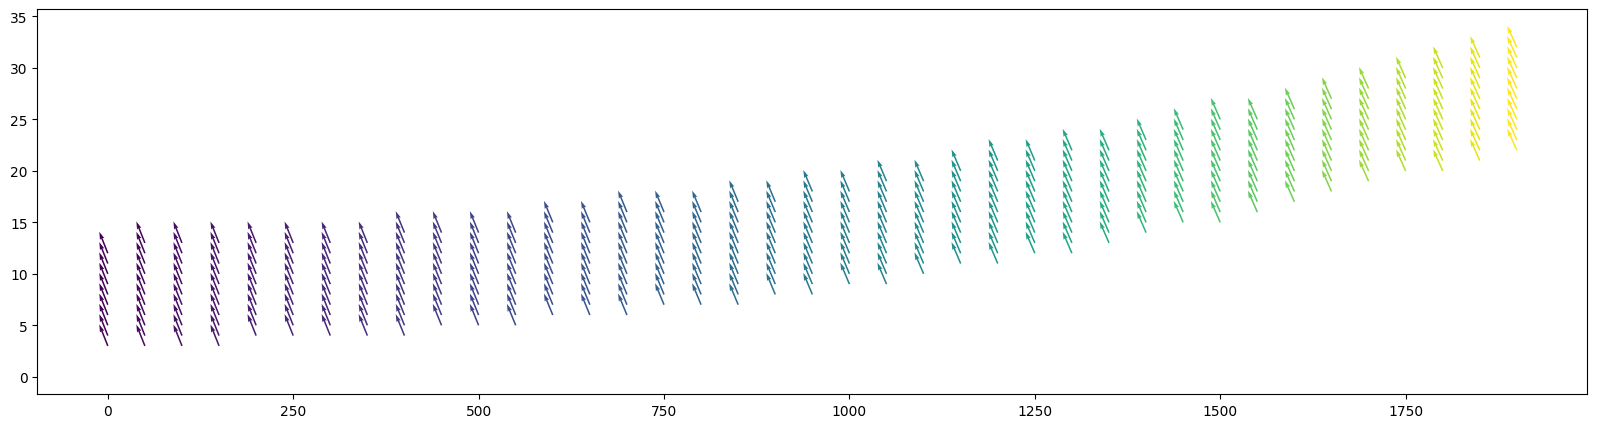

In [238]:
sl = nrs2cal.slits[00]

ypx, xpx = np.meshgrid(*[np.arange(sh) for sh in sl.data.shape])
sc, wl = sl.meta.wcs.pixel_to_world(xpx, ypx)
xpx_rt, ypx_rt = sl.meta.wcs.world_to_pixel(sc, wl)

raoff = sc.ra + 1*u.marcsec
decoff = sc.dec + 1*u.marcsec
newsky = SkyCoord(ra=raoff, dec=decoff)
xoff, yoff = sl.meta.wcs.world_to_pixel(newsky, wl)

dx = xoff - xpx_rt
dy = yoff - ypx_rt

sel = slice(None, None, 50)

plt.figure(figsize=(20, 5))
plt.quiver(xpx[sel], ypx[sel], dx[sel], dy[sel], np.hypot(dx[sel], dy[sel]), angles='xy', 
           width=.001)

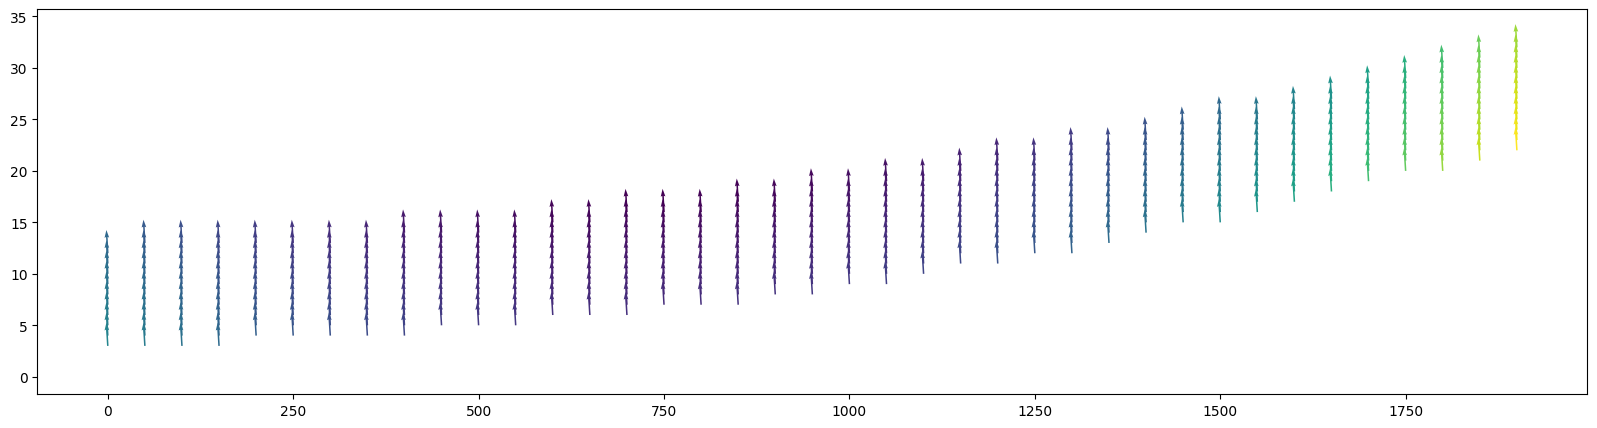

In [249]:
sl = nrs2cal.slits[00]

ypx, xpx = np.meshgrid(*[np.arange(sh) for sh in sl.data.shape])
sc, wl = sl.meta.wcs.pixel_to_world(xpx, ypx)
xpx_rt, ypx_rt = sl.meta.wcs.world_to_pixel(sc, wl)

raoff = sc.ra + 0*u.marcsec
decoff = sc.dec + 1*u.marcsec
newsky = SkyCoord(ra=raoff, dec=decoff)
xoff, yoff = sl.meta.wcs.world_to_pixel(newsky, wl)

dx = xoff - xpx_rt
dy = yoff - ypx_rt

sel = slice(None, None, 50)

plt.figure(figsize=(20, 5))
plt.quiver(xpx[sel], ypx[sel], dx[sel], dy[sel], np.hypot(dx[sel], dy[sel]), angles='xy', 
           width=.001)

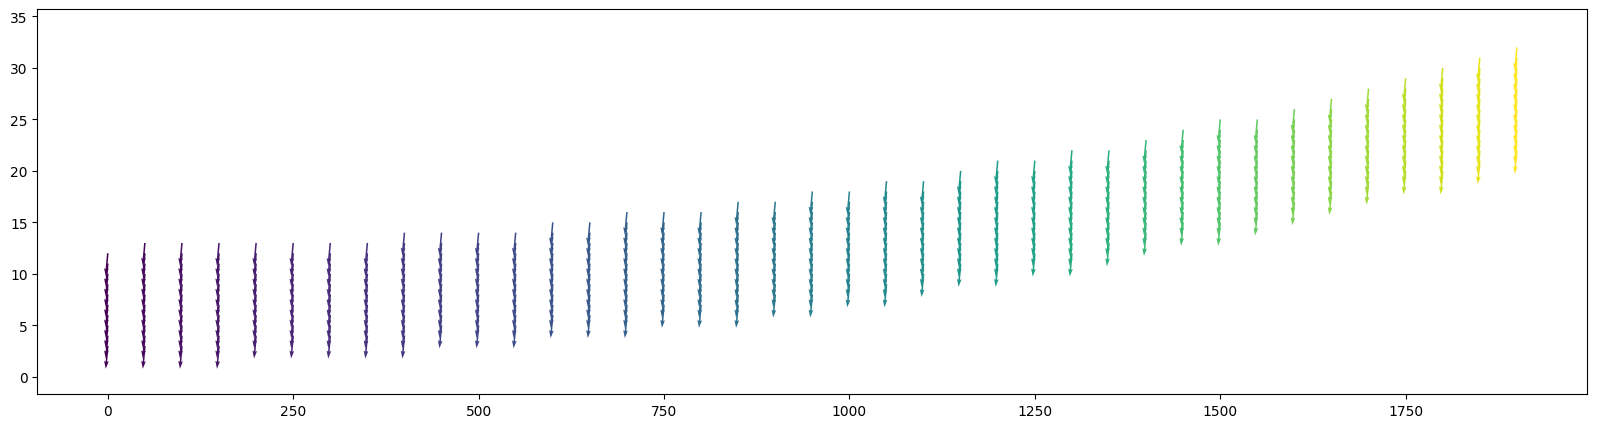

In [250]:
sl = nrs2cal.slits[00]

ypx, xpx = np.meshgrid(*[np.arange(sh) for sh in sl.data.shape])
sc, wl = sl.meta.wcs.pixel_to_world(xpx, ypx)
xpx_rt, ypx_rt = sl.meta.wcs.world_to_pixel(sc, wl)

raoff = sc.ra + 1*u.marcsec
decoff = sc.dec + 0*u.marcsec
newsky = SkyCoord(ra=raoff, dec=decoff)
xoff, yoff = sl.meta.wcs.world_to_pixel(newsky, wl)

dx = xoff - xpx_rt
dy = yoff - ypx_rt

sel = slice(None, None, 50)

plt.figure(figsize=(20, 5))
plt.quiver(xpx[sel], ypx[sel], dx[sel], dy[sel], np.hypot(dx[sel], dy[sel]), angles='xy', 
           width=.001)

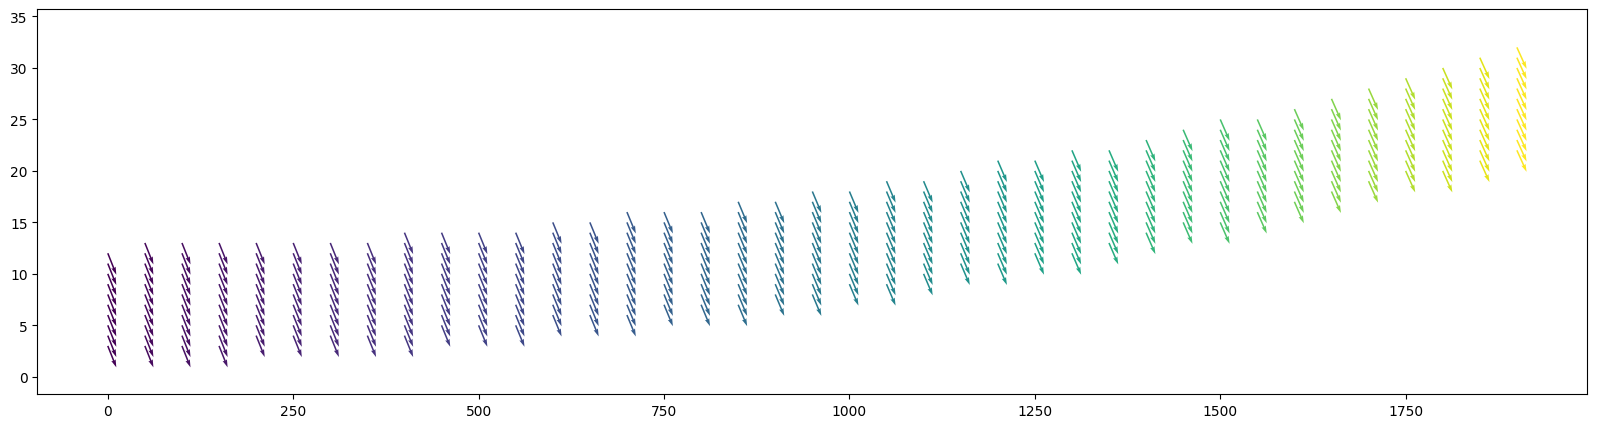

In [251]:
sl = nrs2cal.slits[00]

ypx, xpx = np.meshgrid(*[np.arange(sh) for sh in sl.data.shape])
sc, wl = sl.meta.wcs.pixel_to_world(xpx, ypx)
xpx_rt, ypx_rt = sl.meta.wcs.world_to_pixel(sc, wl)

raoff = sc.ra - 1*u.marcsec
decoff = sc.dec - 1*u.marcsec
newsky = SkyCoord(ra=raoff, dec=decoff)
xoff, yoff = sl.meta.wcs.world_to_pixel(newsky, wl)

dx = xoff - xpx_rt
dy = yoff - ypx_rt

sel = slice(None, None, 50)

plt.figure(figsize=(20, 5))
plt.quiver(xpx[sel], ypx[sel], dx[sel], dy[sel], np.hypot(dx[sel], dy[sel]), angles='xy', 
           width=.001)

Oooh, right... it's not mapping out the slit, but rather where the *center* of the slit lies in wl/ra/dec sppace...